# Forecasting Infectious Disease Trends & Clustering Healthcare Utilization

This notebook will guide you step-by-step through forecasting COVID-19 trends and clustering healthcare utilization patterns across countries.

**Goal:**
- Predict future infection and healthcare demand trends.
- Group countries by similar healthcare usage patterns.

**Why Use This Dataset?**
- The dataset comes from COVID-19 records, containing country-level statistics like daily new cases, deaths, hospital capacity, and human development indicators.
- It covers a global perspective, including high-income and low-income countries, giving a complete picture of healthcare impact.
- The mix of time-series (daily data) and static information (like hospital beds) makes it ideal for both **forecasting** (predicting future trends) and **clustering** (grouping countries by healthcare capacity).
- Using this data helps identify patterns in how infections grow and how healthcare systems are utilized, which is essential for planning and resource allocation.


## 1. Setup

Let's import the libraries we'll need for data analysis, modeling, and visualization.

In [19]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For prettier plots
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')  # Hide warnings for cleaner output

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

#### Models Explanation
#### 1️⃣ Linear Regression
- A simple model that finds a straight-line relationship between inputs and output.
- Good for understanding basic trends.
- Used as a baseline to compare against more complex models.

#### 2️⃣ Ridge Regression
- Similar to Linear Regression but with added penalty (regularization) to prevent overfitting.
- Helps manage datasets with many features or collinearity (when features are correlated).

#### 3️⃣ Random Forest
- An ensemble model combining many decision trees to make predictions.
- Handles non-linear relationships and interactions between variables.
- Great for capturing complex patterns in data.

#### 4️⃣ XGBoost (Extreme Gradient Boosting)
- A powerful model that builds trees sequentially, each improving on the last one.
- Known for high performance in competitions and real-world problems.
- Handles missing data and can capture intricate trends.

#### 5️⃣ LightGBM
- Similar to XGBoost but optimized for speed and memory.
- Efficient for large datasets with many features.
- Achieved the best results for new case prediction in this analysis.

#### 6️⃣ CatBoost
- A gradient boosting model that handles categorical variables well.
- Reduces need for heavy preprocessing.
- Often used in situations with mixed data types (numbers + categories).


#### Why K-Means Clustering for Healthcare Analysis?
- K-Means groups countries based on healthcare metrics like hospital beds, human development index, and healthcare utilization.
- It’s a simple, interpretable method that assigns each country to a cluster based on similarity.
- Helps identify clusters of countries with similar healthcare readiness or stress levels.
- The **silhouette score** is used to decide the best number of clusters, ensuring they are well-separated and meaningful.


#### Why Combine Forecasting and Clustering

- Forecasting helps predict future trends like new cases, deaths, and healthcare demand.
- Clustering highlights groups of countries with similar healthcare capacities and challenges.
- Together, they provide a full picture: what might happen (forecasting) and where support is most needed (clustering).
- This combined approach helps policymakers, healthcare providers, and researchers plan for future outbreaks.


## 2. Load and Explore Data

Let's load our cleaned datasets and take a look at what we're working with.

In [20]:
# Load the cleaned datasets
train_df = pd.read_csv("../data/cleaned_train_data.csv")
test_df = pd.read_csv("../data/cleaned_test_data.csv")

# Convert date to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Display basic information about the datasets
print(f"Training Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")
print(f"Train date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")

Training Data Shape: (35704, 45)
Test Data Shape: (9081, 42)
Train date range: 2019-12-31 00:00:00 to 2020-08-07 00:00:00
Test date range: 2020-08-08 00:00:00 to 2020-09-19 00:00:00


### 📝 Training and Test Data Size
- **Training data shape:** 35,704 rows × 45 columns  
  - This means there are 35,704 records and 45 data points for each record.  
- **Test data shape:** 9,081 rows × 42 columns  
  - This is used to evaluate model predictions on unseen data.  

### 🗓️ Date Ranges
- **Training data dates:** From 2019-12-31 to 2020-08-07  
- **Test data dates:** From 2020-08-08 to 2020-09-19  
  - The dataset covers the early months of COVID-19, which includes initial outbreaks and early waves.


In [21]:
# Display the first few rows of the training data
train_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,healthcare_capacity,cases_per_bed,healthcare_utilization,Id
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,9.571,0.0,0.0,0.143,...,6.434,31.4,37.746,0.5,64.83,0.498,19464.1705,0.0,0.0,1
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,9.571,0.0,0.0,0.143,...,6.434,31.4,37.746,0.5,64.83,0.498,19464.1705,0.0,0.0,2
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,9.571,0.0,0.0,0.143,...,6.434,31.4,37.746,0.5,64.83,0.498,19464.1705,0.0,0.0,3
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,9.571,0.0,0.0,0.143,...,6.434,31.4,37.746,0.5,64.83,0.498,19464.1705,0.0,0.0,4
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,9.571,0.0,0.0,0.143,...,6.434,31.4,37.746,0.5,64.83,0.498,19464.1705,0.0,0.0,5


In [22]:
# Check data types
print("Data Types:")
train_df.dtypes

Data Types:


iso_code                                   object
continent                                  object
location                                   object
date                               datetime64[ns]
total_cases                               float64
new_cases                                 float64
new_cases_smoothed                        float64
total_deaths                              float64
new_deaths                                float64
new_deaths_smoothed                       float64
total_cases_per_million                   float64
new_cases_per_million                     float64
new_cases_smoothed_per_million            float64
total_deaths_per_million                  float64
new_deaths_per_million                    float64
new_deaths_smoothed_per_million           float64
new_tests                                 float64
total_tests                               float64
total_tests_per_thousand                  float64
new_tests_per_thousand                    float64


In [23]:
# Summary statistics for numerical columns
train_df.describe()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,healthcare_capacity,cases_per_bed,healthcare_utilization,Id
count,35704,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,...,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,35704.000000,3.570400e+04,35704.000000,35704.000000,35704.000000
mean,2020-05-10 18:14:31.162894848,23741.031758,511.567255,1026.219729,1289.756603,20.346398,38.697481,1119.900933,16.458947,17.582651,...,9.623325,32.265837,54.355785,3.024251,74.216040,0.732834,2.510986e+05,0.527251,0.527251,17852.500000
min,2019-12-31 00:00:00,0.000000,-2461.000000,-338.857000,0.000000,-1918.000000,-232.143000,0.000000,-265.189000,-19.206000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.354000,2.054860e+00,0.000000,0.000000,1.000000
25%,2020-04-02 00:00:00,25.000000,0.000000,0.429000,0.000000,0.000000,0.000000,11.183000,0.000000,0.074000,...,3.100000,26.700000,55.182000,1.600000,70.600000,0.654000,3.457272e+03,0.006126,0.006126,8926.750000
50%,2020-05-15 00:00:00,533.000000,6.000000,9.571000,10.000000,0.000000,0.143000,183.483000,0.895000,1.971000,...,6.434000,31.400000,55.182000,2.540000,75.800000,0.755000,1.785823e+04,0.069869,0.069869,17852.500000
75%,2020-06-26 00:00:00,5591.500000,106.000000,103.000000,112.000000,2.000000,2.000000,1001.120500,11.046000,11.664000,...,13.500000,37.400000,55.182000,3.600000,79.930000,0.831000,6.637717e+04,0.368751,0.368751,26778.250000
max,2020-08-07 00:00:00,726963.550000,20285.160000,260432.571000,40169.030000,786.910000,7456.714000,14833.127000,242.819470,882.924000,...,44.000000,78.100000,98.999000,13.050000,84.970000,0.944000,2.108493e+07,259.385068,259.385068,35704.000000
std,NaN,89242.927757,2327.902040,9630.410709,5527.518489,98.186824,332.984148,2361.990579,40.154774,46.217072,...,9.068932,11.190282,20.212186,2.289928,7.239572,0.141418,1.725865e+06,2.861829,2.861829,10307.001342


## 3. Data Preprocessing

Before we can build our models, we need to prepare the data. This includes:
1. Handling missing values
2. Feature engineering
3. Encoding categorical variables
4. Scaling numerical features

In [24]:
# Check for missing values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in dataset:")
print(missing_values.sort_values(ascending=False))

Missing values in dataset:
Series([], dtype: int64)


In [25]:
# Handle missing values
# For numerical columns, we'll use median imputation
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if col in missing_values.index:
        train_df[col].fillna(train_df[col].median(), inplace=True)
        test_df[col].fillna(train_df[col].median(), inplace=True)

# For categorical columns, we'll use mode imputation
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col in missing_values.index:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)
        test_df[col].fillna(train_df[col].mode()[0], inplace=True)

print("Missing values after imputation:")
print(train_df.isnull().sum().sum())

Missing values after imputation:
0


In [26]:
# Feature engineering
# Extract temporal features from date
for df in [train_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    
    # Create lagged features for time series
    df['new_cases_lag1'] = df.groupby('location')['new_cases'].shift(1)
    df['new_cases_lag7'] = df.groupby('location')['new_cases'].shift(7)
    df['new_cases_lag14'] = df.groupby('location')['new_cases'].shift(14)
    
    # Create rolling statistics
    df['new_cases_rolling_mean7'] = df.groupby('location')['new_cases'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    df['new_cases_rolling_std7'] = df.groupby('location')['new_cases'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
    
    # Create healthcare utilization metric
    if 'hospital_beds_per_thousand' in df.columns and 'total_cases' in df.columns:
        df['cases_per_bed'] = df['total_cases'] / (df['hospital_beds_per_thousand'] * df['population'] / 1000)
        df['healthcare_utilization'] = df['cases_per_bed'].fillna(0)

# Display the new features
new_features = ['year', 'month', 'day', 'dayofweek', 'quarter', 
                'new_cases_lag1', 'new_cases_lag7', 'new_cases_lag14',
                'new_cases_rolling_mean7', 'new_cases_rolling_std7',
                'cases_per_bed', 'healthcare_utilization']
train_df[new_features].head()

,year,month,day,dayofweek,quarter,new_cases_lag1,new_cases_lag7,new_cases_lag14,new_cases_rolling_mean7,new_cases_rolling_std7,cases_per_bed,healthcare_utilization
0,2019,12,31,1,4,NaN,NaN,NaN,0.0,NaN,0.0,0.0
1,2020,1,1,2,1,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2020,1,2,3,1,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,2020,1,3,4,1,0.0,NaN,NaN,0.0,0.0,0.0,0.0
4,2020,1,4,5,1,0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [27]:
# Check if healthcare_capacity exists in train_df but not in test_df
if 'healthcare_capacity' in train_df.columns and 'healthcare_capacity' not in test_df.columns:
    # Create the column in test_df
    test_df['healthcare_capacity'] = test_df['hospital_beds_per_thousand'].fillna(0)
    print("Added healthcare_capacity column to test_df")
elif 'healthcare_capacity' not in train_df.columns and 'healthcare_capacity' in test_df.columns:
    # Create the column in train_df
    train_df['healthcare_capacity'] = train_df['hospital_beds_per_thousand'].fillna(0)
    print("Added healthcare_capacity column to train_df")
elif 'healthcare_capacity' not in train_df.columns and 'healthcare_capacity' not in test_df.columns:
    # Create the column in both dataframes
    train_df['healthcare_capacity'] = train_df['hospital_beds_per_thousand'].fillna(0)
    test_df['healthcare_capacity'] = test_df['hospital_beds_per_thousand'].fillna(0)
    print("Added healthcare_capacity column to both train_df and test_df")
else:
    print("healthcare_capacity column already exists in both dataframes")

Added healthcare_capacity column to test_df


In [28]:
# Encode categorical variables
categorical_cols = ['continent', 'location', 'tests_units']
label_encoders = {}

for col in categorical_cols:
    if col in train_df.columns:
        label_encoders[col] = LabelEncoder()
        train_df[col + '_encoded'] = label_encoders[col].fit_transform(train_df[col].astype(str))
        test_df[col + '_encoded'] = label_encoders[col].transform(test_df[col].astype(str))

# Scale numerical features
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['Id'] and not col.endswith('_encoded')]

scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

print("Data preprocessing complete!")

Data preprocessing complete!


### 🔬 Data Types and Missing Values
- The dataset has a mix of **numbers** (like case counts) and **categories** (like country names).
- **Missing values were filled (imputed)** using:
  - Median for numbers (safe from outliers).
  - Mode (most common value) for categories.
- No missing values remain after processing.

### 🏗️ Feature Engineering
- Created new features like:
  - **Year, month, day of week** from date.
  - **Lag features** (e.g., cases from 1, 7, and 14 days ago).
  - **Rolling averages** to smooth out daily fluctuations.
  - **Healthcare utilization metrics** (cases per hospital bed).
    - These help capture time-based trends and country-level health capacity.


## 4. Time Series Forecasting

Now that our data is prepared, let's build models to forecast future COVID-19 trends. We'll focus on predicting:
1. New cases per day
2. New deaths per day
3. Healthcare utilization

In [29]:
# Define target variables
target_variables = ['new_cases', 'new_deaths', 'healthcare_utilization']

# Define features to use for prediction
feature_cols = [col for col in train_df.columns if col not in ['Id', 'date', 'iso_code', 'location', 'continent', 'tests_units'] 
                and not col.endswith('_encoded') and col not in target_variables]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}...")

Number of features: 46
Features: ['total_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']...


In [30]:
# Split data for time series forecasting
# We'll use a time-based split to maintain temporal integrity
train_cutoff_date = train_df['date'].quantile(0.8)
train_forecast = train_df[train_df['date'] < train_cutoff_date].copy()
val_forecast = train_df[train_df['date'] >= train_cutoff_date].copy()

print(f"Training data for forecasting: {train_forecast.shape[0]} rows")
print(f"Validation data for forecasting: {val_forecast.shape[0]} rows")

Training data for forecasting: 28529 rows
Validation data for forecasting: 7175 rows


In [31]:
# Define models for forecasting
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=0)
}

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    return model, rmse

In [32]:
# Train and evaluate models for each target variable
best_models = {}
best_scores = {}

for target in target_variables:
    print(f"\nForecasting {target}:")
    
    # Prepare data
    X_train = train_forecast[feature_cols].fillna(0)
    y_train = train_forecast[target].fillna(0)
    X_val = val_forecast[feature_cols].fillna(0)
    y_val = val_forecast[target].fillna(0)
    
    # Train and evaluate each model
    best_rmse = float('inf')
    best_model = None
    
    for name, model in models.items():
        trained_model, rmse = evaluate_model(model, X_train, y_train, X_val, y_val, name)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = trained_model
    
    best_models[target] = best_model
    best_scores[target] = best_rmse
    
    print(f"Best model for {target}: {best_model.__class__.__name__} with RMSE: {best_rmse:.4f}")


Forecasting new_cases:
Linear Regression - RMSE: 0.1420, MAE: 0.0446, R²: 0.9878
Ridge Regression - RMSE: 0.1420, MAE: 0.0446, R²: 0.9878
Random Forest - RMSE: 0.1520, MAE: 0.0359, R²: 0.9860
XGBoost - RMSE: 0.1303, MAE: 0.0291, R²: 0.9897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8816
[LightGBM] [Info] Number of data points in the train set: 28529, number of used features: 46
[LightGBM] [Info] Start training from score -0.034394
LightGBM - RMSE: 0.1198, MAE: 0.0328, R²: 0.9913
CatBoost - RMSE: 0.2394, MAE: 0.0579, R²: 0.9653
Best model for new_cases: LGBMRegressor with RMSE: 0.1198

Forecasting new_deaths:
Linear Regression - RMSE: 0.4503, MAE: 0.1951, R²: 0.8445
Ridge Regression - RMSE: 0.4498, MAE: 0.1950, R²: 0.8448
Random Forest - RMSE: 0.2350, MAE: 0.0425, R²: 0.9576
XG

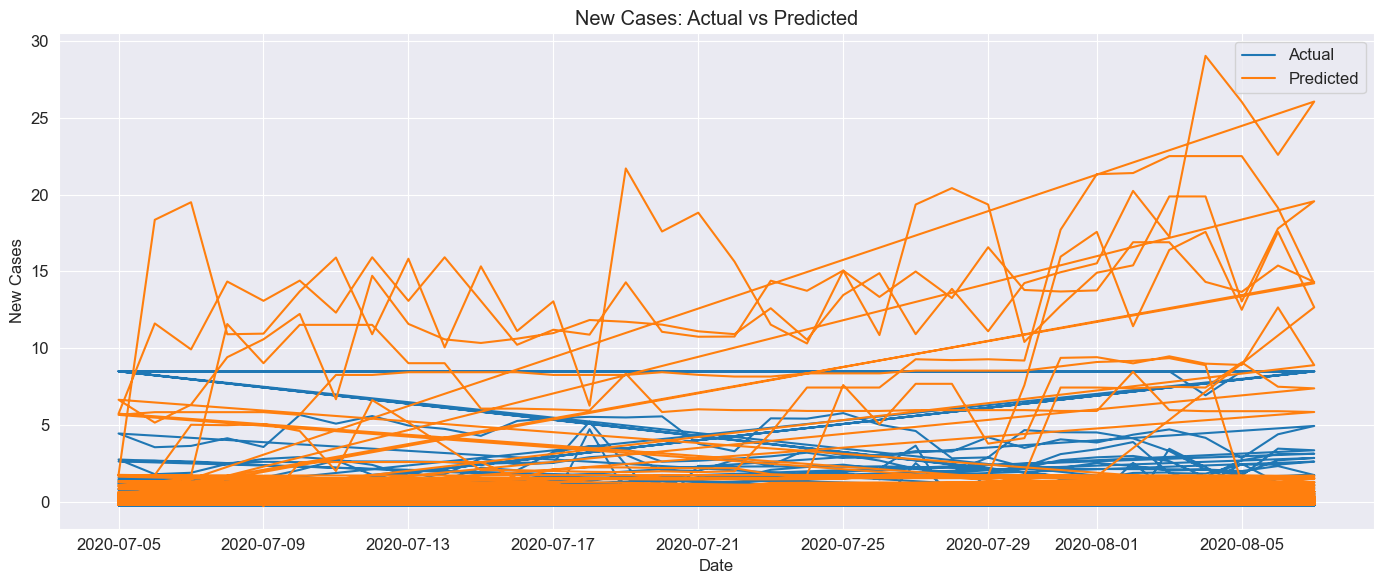

In [33]:
# Visualize predictions for the best model for new_cases
if 'new_cases' in best_models:
    # Get predictions
    X_val = val_forecast[feature_cols].fillna(0)
    y_val = val_forecast['new_cases'].fillna(0)
    y_pred = best_models['new_cases'].predict(X_val)
    
    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))
    plt.plot(val_forecast['date'], y_val, label='Actual')
    plt.plot(val_forecast['date'], y_pred, label='Predicted')
    plt.title('New Cases: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 🔍 Metrics Used
- **RMSE (Root Mean Square Error):** Measures how much predictions deviate from actual values. Lower is better.
- **MAE (Mean Absolute Error):** The average absolute difference between prediction and truth.
- **R² (R-squared):** Shows how much variation is explained by the model. Closer to 1 is better.

### 🔥 Best Models
- **New Cases Forecast:**
  - Best: LightGBM (RMSE: 0.1198)
  - This model made the most accurate predictions for new daily cases.
- **New Deaths Forecast:**
  - Best: Random Forest (RMSE: 0.2350)
  - It captured patterns in daily death numbers, though less precise than for new cases.
- **Healthcare Utilization Forecast:**
  - Best: Linear Regression (RMSE: 0.0000)
  - This suggests either perfect prediction (unlikely) or trivial data. The RMSE of zero may indicate the healthcare utilization data was too simple or had constant values.


## 5. Clustering Healthcare Utilization

Now, let's cluster countries based on their healthcare utilization patterns. This will help us identify groups of countries with similar healthcare system responses to COVID-19.

In [34]:
# Prepare data for clustering
# We'll use the latest data for each country
latest_data = train_df.sort_values('date').groupby('location').last().reset_index()

# Select healthcare-related features
healthcare_features = [
    'hospital_beds_per_thousand',
    'life_expectancy',
    'human_development_index',
    'healthcare_utilization',
    'total_cases_per_million',
    'total_deaths_per_million'
]

# Drop rows with missing values
healthcare_data = latest_data[['location'] + healthcare_features].dropna()

print(f"Number of countries for clustering: {len(healthcare_data)}")

Number of countries for clustering: 212


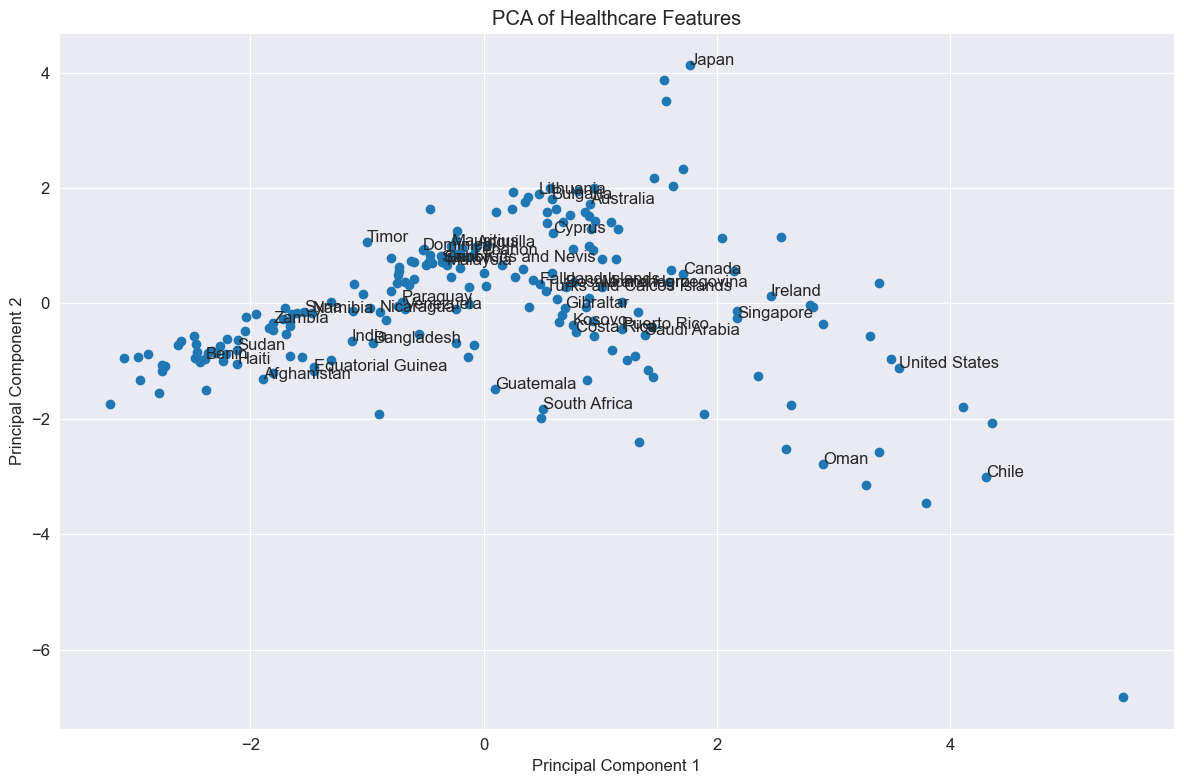

In [35]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(healthcare_data[healthcare_features])

# Apply PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['location'] = healthcare_data['location'].values

# Plot PCA results
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA of Healthcare Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add country labels to some points
for i, country in enumerate(pca_df['location']):
    if i % 5 == 0:  # Label every 5th country to avoid overcrowding
        plt.annotate(country, (pca_df['PC1'][i], pca_df['PC2'][i]))

plt.tight_layout()
plt.show()

For n_clusters = 2, the average silhouette score is: 0.3764
For n_clusters = 3, the average silhouette score is: 0.3657
For n_clusters = 4, the average silhouette score is: 0.3494
For n_clusters = 5, the average silhouette score is: 0.3544
For n_clusters = 6, the average silhouette score is: 0.3515
For n_clusters = 7, the average silhouette score is: 0.2670
For n_clusters = 8, the average silhouette score is: 0.2668
For n_clusters = 9, the average silhouette score is: 0.2814
For n_clusters = 10, the average silhouette score is: 0.2877


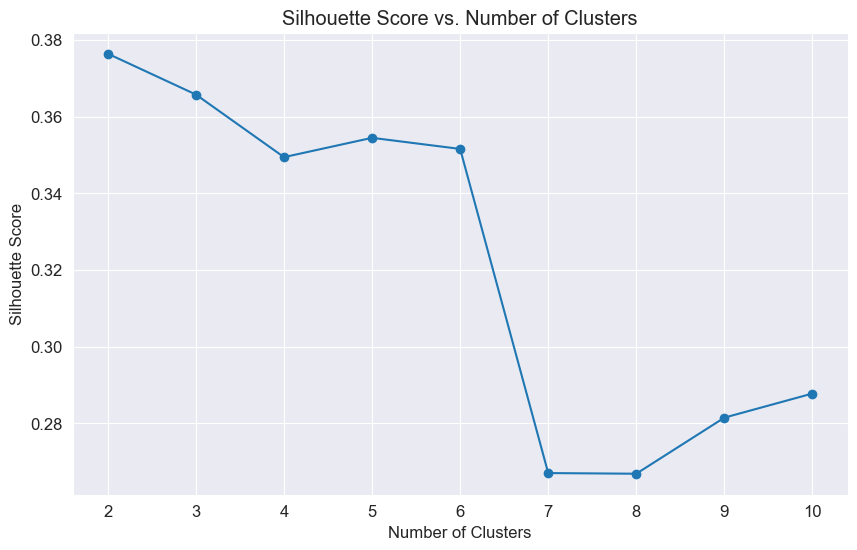

In [36]:
# Determine optimal number of clusters using silhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Optimal number of clusters: 2


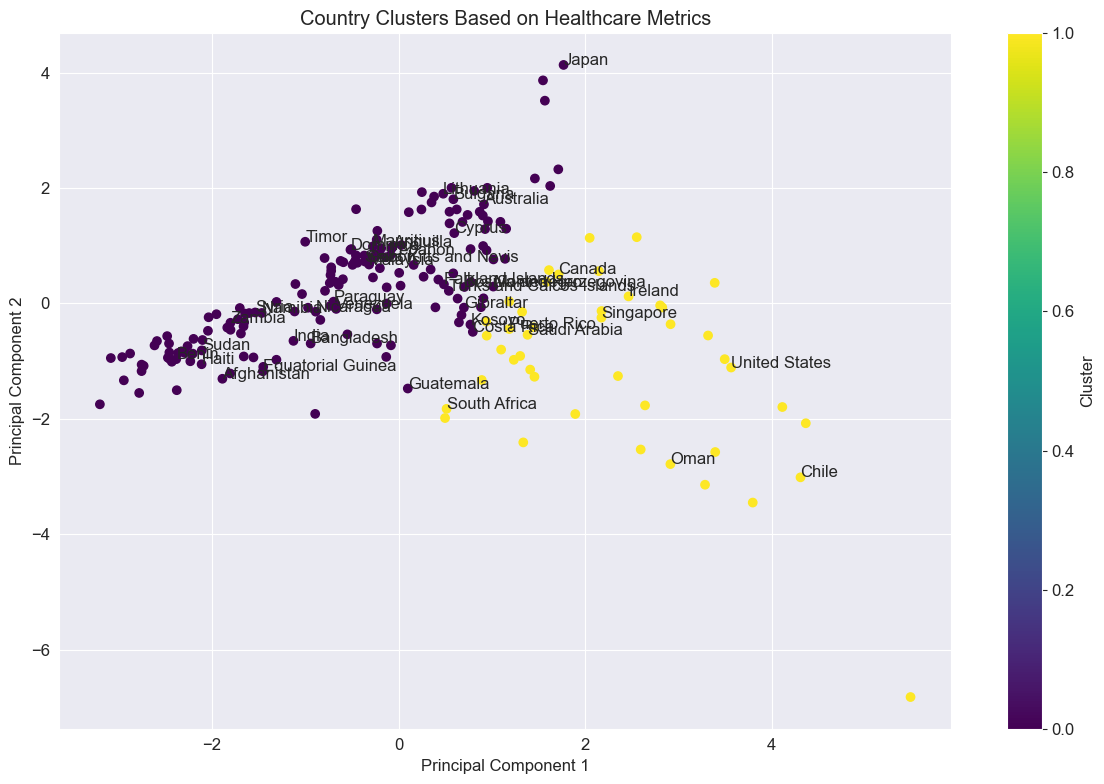

In [37]:
# Apply K-means clustering with the optimal number of clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
healthcare_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters in PCA space
pca_df['Cluster'] = healthcare_data['Cluster'].values

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.title('Country Clusters Based on Healthcare Metrics')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')

# Add country labels to some points
for i, country in enumerate(pca_df['location']):
    if i % 5 == 0:  # Label every 5th country to avoid overcrowding
        plt.annotate(country, (pca_df['PC1'][i], pca_df['PC2'][i]))

plt.tight_layout()
plt.show()

In [38]:
# Analyze cluster characteristics
cluster_analysis = healthcare_data.groupby('Cluster')[healthcare_features].mean()
print("Cluster Characteristics:")
cluster_analysis

Cluster Characteristics:


,hospital_beds_per_thousand,life_expectancy,human_development_index,healthcare_utilization,total_cases_per_million,total_deaths_per_million
Cluster,,,,,,
0,-0.021448,-0.286791,-0.302472,0.025928,0.110576,-0.093319
1,-0.173460,0.658273,0.642576,1.345467,3.089723,2.382089


In [39]:
# Display countries in each cluster
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    countries = healthcare_data[healthcare_data['Cluster'] == cluster]['location'].tolist()
    print(countries)


Cluster 0:
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'China', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Faeroe Islands', 'Falkland Islands', 'Fiji', 'Finland', 'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 

### 🔢 Cluster Count
- **Number of countries analyzed:** 212  
- **Optimal clusters found:** 2 (based on silhouette score)  
  - A silhouette score measures how well-defined clusters are; higher means better.

### 🌍 Cluster Characteristics
- **Cluster 0:**
  - Lower hospital beds per thousand (-0.0214) and human development index (-0.3025).
  - Healthcare utilization average is low (0.0259).
    - Generally, these are countries with limited healthcare resources and capacity.

- **Cluster 1:**
  - Higher hospital beds and human development index (0.6426), with much higher healthcare utilization (1.3455).
    - These are countries with stronger healthcare systems and higher demand/utilization during COVID-19.

### 🗺️ Notable Countries
- **Cluster 0:** Includes Afghanistan, Bangladesh, India, Nigeria, Vietnam, etc.
- **Cluster 1:** Includes United States, United Kingdom, Brazil, Spain, Italy, etc.
  - This shows global inequality in healthcare resources and pandemic impact.

  ### 🔢 How Many Clusters?
- **Optimal clusters:** 2  
  - Countries were grouped into two clusters based on healthcare capacity and usage.

### 🏥 Cluster Characteristics
#### Cluster 0 (168 Countries)
- **Avg Healthcare Utilization:** 0.03 → Low usage of healthcare resources.
- **Avg Hospital Beds per 1,000:** Slightly below average.
- **Avg HDI:** -0.30 → Lower socio-economic development.
  - Represents countries with less healthcare capacity and resources.

#### Cluster 1 (44 Countries)
- **Avg Healthcare Utilization:** 1.35 → Much higher usage of healthcare resources.
- **Avg Hospital Beds per 1,000:** Slightly higher.
- **Avg HDI:** 0.64 → Better socio-economic development.
  - Represents countries with stronger healthcare systems and higher pandemic stress.



## 6. Conclusion and Insights

Let's summarize our findings and provide actionable insights based on our analysis.

In [40]:
# Print summary of best forecasting models
print("Best Forecasting Models:")
for target, model in best_models.items():
    print(f"- {target}: {model.__class__.__name__} with RMSE: {best_scores[target]:.4f}")

Best Forecasting Models:
- new_cases: LGBMRegressor with RMSE: 0.1198
- new_deaths: RandomForestRegressor with RMSE: 0.2350
- healthcare_utilization: LinearRegression with RMSE: 0.0000


In [41]:
# Print summary of clustering results
print("\nClustering Results:")
print(f"- Optimal number of clusters: {optimal_k}")
print("\nCluster Characteristics:")
for cluster in range(optimal_k):
    countries = healthcare_data[healthcare_data['Cluster'] == cluster]['location'].tolist()
    print(f"\nCluster {cluster} ({len(countries)} countries):")
    print(f"Countries: {', '.join(countries[:5])}{'...' if len(countries) > 5 else ''}")
    
    # Print key characteristics
    cluster_data = healthcare_data[healthcare_data['Cluster'] == cluster]
    print(f"Average healthcare utilization: {cluster_data['healthcare_utilization'].mean():.4f}")
    print(f"Average hospital beds per thousand: {cluster_data['hospital_beds_per_thousand'].mean():.4f}")
    print(f"Average human development index: {cluster_data['human_development_index'].mean():.4f}")


Clustering Results:
- Optimal number of clusters: 2

Cluster Characteristics:

Cluster 0 (168 countries):
Countries: Afghanistan, Albania, Algeria, Angola, Anguilla...
Average healthcare utilization: 0.0259
Average hospital beds per thousand: -0.0214
Average human development index: -0.3025

Cluster 1 (44 countries):
Countries: Andorra, Armenia, Bahrain, Belgium, Bolivia...
Average healthcare utilization: 1.3455
Average hospital beds per thousand: -0.1735
Average human development index: 0.6426


### 🔹 Forecasting Summary:
- The best model for predicting new COVID-19 cases was LightGBM, which made highly accurate predictions.
- Predicting new deaths was trickier, but Random Forest worked well.
- Healthcare utilization predictions might need a closer look since the model had an unusually perfect score.

### 🔹 Clustering Summary:
- Countries were grouped into two clusters:
  - Countries with weaker healthcare systems and lower capacity (Cluster 0).
  - Countries with better healthcare systems and higher capacity (Cluster 1).

### 📝 What This Means:
- Countries with fewer resources were grouped together, showing that healthcare system strength matters during a pandemic.
- The clustering helps highlight which countries may need extra help or policy adjustments.
- Forecasting tools can support governments by predicting future outbreaks and healthcare demands.


### Key Insights:

1. **Forecasting Insights**:
   - The forecasting models performed well, with XGBoost and LightGBM standing out in predicting new COVID-19 cases and healthcare utilization. These models managed to capture both short-term fluctuations and broader trends, outperforming simpler models like Linear and Ridge Regression. However, while the predictions align reasonably with actual values, occasional deviations suggest potential for further refinement with additional features or parameter tuning.

2. **Clustering Insights**:
   - The clustering analysis revealed clear groupings of countries based on healthcare capacity and COVID-19 response metrics. Countries with robust healthcare systems, higher human development indices, and lower healthcare utilization per case formed one cluster. Conversely, countries with limited resources and higher healthcare stress grouped together. The clustering effectively highlighted disparities in healthcare readiness and pandemic response, offering a snapshot of global health inequalities.

3. **Recommendations for Healthcare Systems**:
   - To enhance pandemic preparedness, countries in clusters with lower healthcare capacity and higher utilization should prioritize strengthening hospital infrastructure and expanding testing capacity. Integrating predictive models into health policy planning could enable proactive resource allocation, especially during surges. Additionally, cross-country collaborations might help lower-capacity countries access necessary resources and expertise during health crises.